In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random
import statistics

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [4]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G = S[0]

The total number of components is:  12219


In [5]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [6]:
G_bipartite = nx.Graph()
for node in nodes:
    if list(node.labels)[0] != 'Entity':
        if node.id in G.nodes:
            G_bipartite.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)
vuelta = 0
for officer in labels['Officer']:
    officer_dict = {}
    for officer_neighbors in G.edges(officer):
        for entity_neighbors in G.edges(officer_neighbors[1]):
            if G.nodes[entity_neighbors[1]]['kind'] == 'Intermediary':
                if entity_neighbors[1] in officer_dict:
                    officer_dict[entity_neighbors[1]] =  officer_dict[entity_neighbors[1]] +1
                else:
                    officer_dict[entity_neighbors[1]] = 1
    for k,v in officer_dict.items():
        G_bipartite.add_edge(officer, k, weight=v, type='Interactions')

In [7]:
A=nx.bipartite.biadjacency_matrix(G_bipartite, labels['Officer'], labels['Intermediary'])

In [8]:
A.todense()

matrix([[   1,    0,    0, ...,    0,    0,    0],
        [1947,   23,   20, ...,    0,    0,    0],
        [   1,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

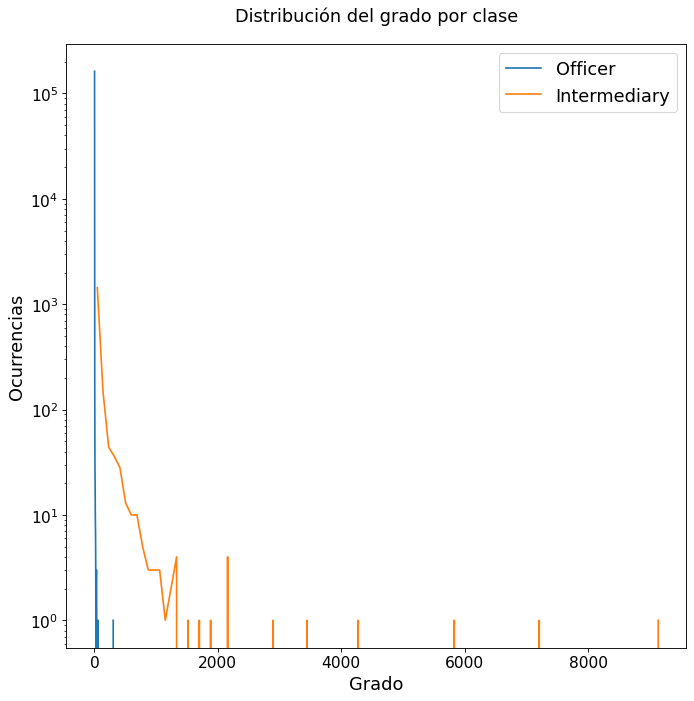

In [9]:
# Degree distribution by class
histogram_degrees_officer = list(dict(G_bipartite.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G_bipartite.degree(labels['Intermediary'])).values())

plt.figure(figsize=(10, 10), dpi=80)

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Distribución del grado por clase',fontsize=16,pad=20)
plt.xlabel('Grado',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
p.show()

In [10]:
j2 = [i for i in histogram_degrees_officer if i > 1]
len(j2)

2576

In [11]:
sorted(histogram_degrees_intermediaries)[-1]

9183

In [12]:
# avg degree officers
np.mean(histogram_degrees_officer)

1.0314719441153541

In [13]:
# avg degree intermediaries
np.mean(histogram_degrees_intermediaries)

95.36549375709421

In [14]:
# Dict node weight
weight_dict = {}
for u,v,data in G_bipartite.edges(data=True):
    weight_dict[u] = weight_dict.get(u, [])
    weight_dict[u].append(data['weight'])
    weight_dict[v] = weight_dict.get(v, [])
    weight_dict[v].append(data['weight'])

In [15]:
weight_dict_mean = {}
for key,value in weight_dict.items():
    weight_dict_mean[key] = statistics.mean(value)

In [16]:
## Graph bipartite associativity compute
scatter_associativity_officer_mean = []
scatter_associativity_intermediary_mean = []
scatter_associativity_officer_weight_mean = []
scatter_associativity_intermediary_weight_mean = []

for node_id,metadata in G_bipartite.nodes(data=True):
    node_degree = G_bipartite.degree(node_id)
    degree_mean = 0
    weight_mean = 0
    number_of_neighbors = len(list(G_bipartite.neighbors(node_id)))
    ## Iterate over neighbors
    for node_neighbor in G_bipartite.neighbors(node_id):
        neighbor_degree = G_bipartite.degree(node_neighbor)
        degree_mean = neighbor_degree + degree_mean
        weight_mean = weight_mean + weight_dict_mean[node_neighbor]
    if G_bipartite.nodes[node_id]['kind'] == 'Intermediary':
        scatter_associativity_intermediary_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_intermediary_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))
    else:
        scatter_associativity_officer_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_officer_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))        

In [34]:
sorted(x_intermediary)[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

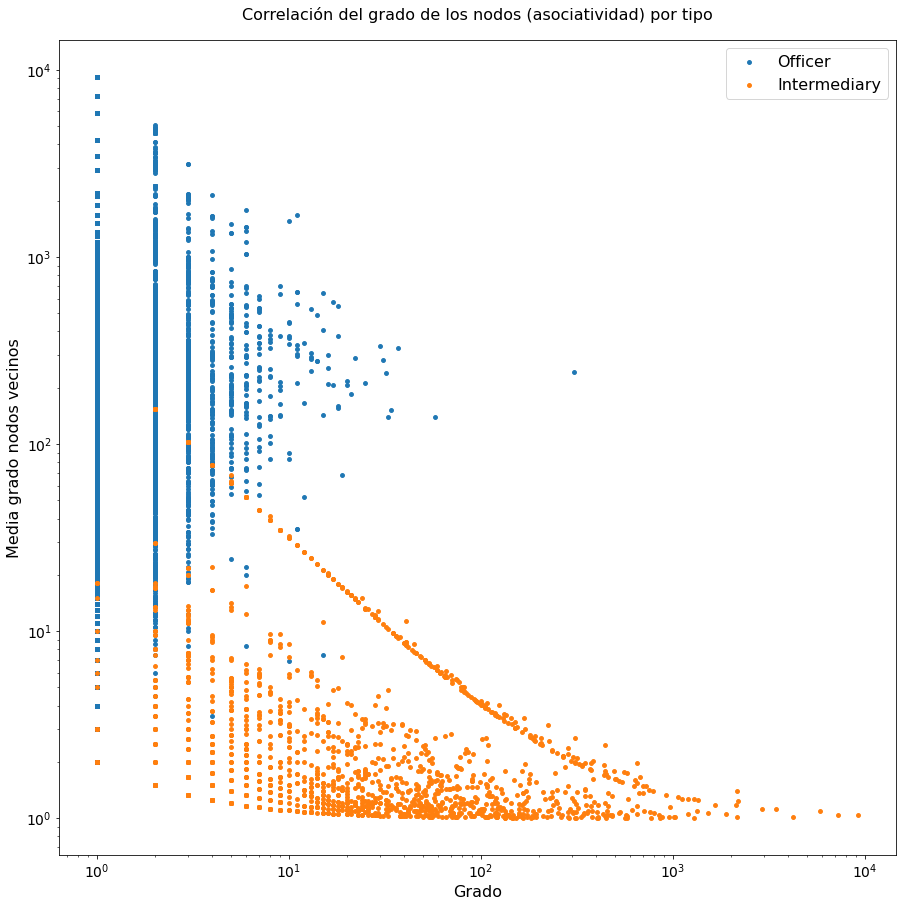

In [18]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
np.mean(y_intermediary)

In [ ]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_weight_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_weight_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Peso', fontsize=16)
plt.ylabel('Media peso nodos vecinos', fontsize=16)
plt.title('Correlación del peso de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
for key,value in weight_dict_mean.items():
    if value > 100:
        print(key)

In [ ]:
G_bipartite.nodes[221955]

In [ ]:
officer_dict = dict(G_bipartite.degree(labels['Officer']))
sorted_officer_dict = list(dict(sorted(officer_dict.items(), key=lambda item: item[1],reverse=True)).keys())

intermediary_dict = dict(G_bipartite.degree(labels['Intermediary']))
sorted_intermediary_dict = list(dict(sorted(intermediary_dict.items(), key=lambda item: item[1],reverse=True)).keys())

In [ ]:
A=nx.bipartite.biadjacency_matrix(G_bipartite, sorted_officer_dict, sorted_intermediary_dict)

In [45]:
A_dense.shape

(162907, 1762)

In [47]:
A_dense = A.todense().T
A_dense = A_dense.astype('float')
A_dense[A_dense==0.0] = np.nan

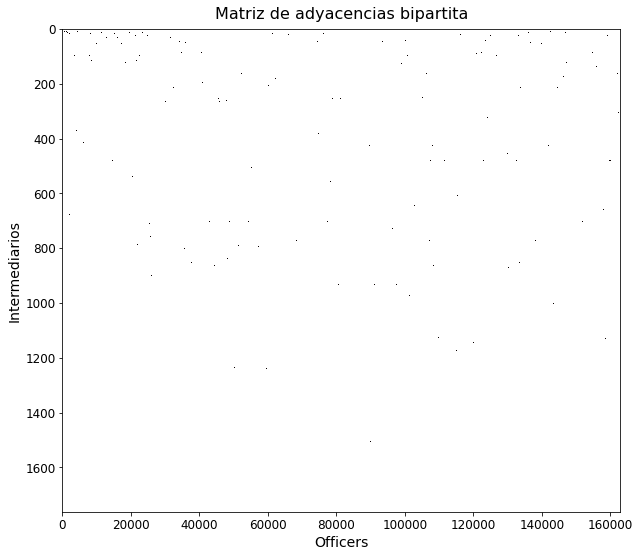

In [50]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
#plt.xlim(0,100000)
#plt.ylim(1000,1762)
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

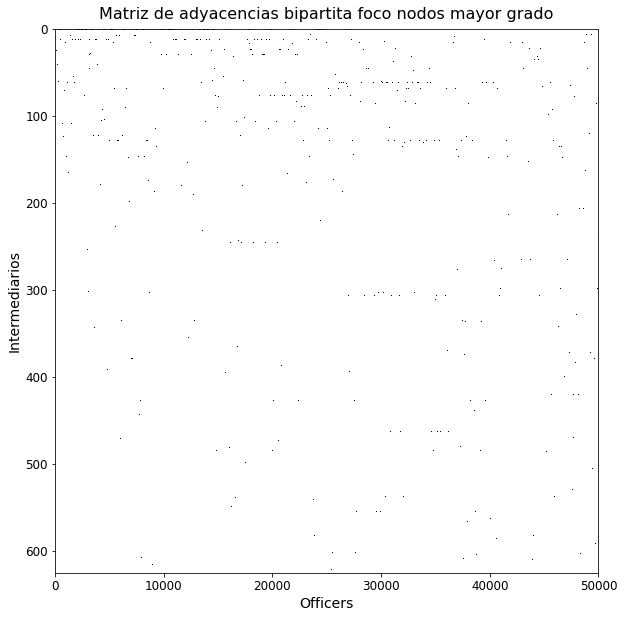

In [51]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita foco nodos mayor grado",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
plt.xlim(0,50000)
plt.ylim(625,0)
plt.xlabel("Officers")
plt.ylabel("Intermediarios")
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

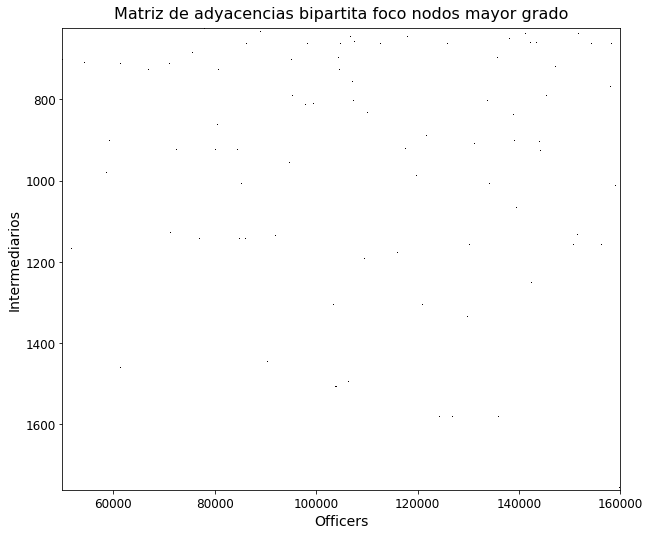

In [53]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita foco nodos mayor grado",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
plt.xlim(50000,160000)
plt.ylim(1762,625)
plt.xlabel("Officers")
plt.ylabel("Intermediarios")
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [36]:
nx.write_gexf(G_bipartite, "bipartite.gexf")

In [44]:
print(1)

1


In [45]:
nx.is_connected(G_bipartite)

True

In [47]:
G_bipartite.number_of_nodes()

164669

In [48]:
len(labels['Intermediary'])

1762

In [49]:
len(labels['Officer'])

162907